# Utilizando Redes Convolucionais para classificação de imagens.
 

> Na atual pós-modernidade, a humanidade sempre esteve em busca de métodos inteligentes e automatizaveis que pudessem promover economia de tempo, aumentos de peformance, competitividade e disponibilidade além de economia de custos. Nesse contexto aplicações de Inteligência artificial vem sendo estudadas desde a metade do seculo XX, pórem apenas nos ultimos 20 tornando estas aplicações começaram a ter maior destaque.

> Partindo desse ponto, este notebook tem o intuito de ilustar e explicar alguns detalhes sobre o funcionamento de uma rede neural artificial. O exemplo utilizado será de uma rede convolucional, que é uma categoria de RNA usualmente utilizada na classificação de imagens e detecção de objetos em imagens.

>O Dataset que fornecera imagens de exemplo para treinamento e teste da RNA é o CIFAR-10, amplamente disponivel na internt. Ele contem 10 classes de imagens que variam de veículos a animais. Explicado estes pontos, o processo será iniciado primeiramente atráves da importação das bibliotecas que serão utilizadas.
<center>
<img alt='tarefas de visão computacional' widht='50%' src=https://miro.medium.com/max/5856/1*Hz6t-tokG1niaUfmcysusw.jpeg>
</img>
</center>

In [ ]:
# Implementação da rede
import torch
from torch import nn, optim

# Carregamento de Dados
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision import transforms

from torch import optim
import torch.nn.functional as F

# Plots e análises
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time, os

%matplotlib inline

## Obtenção de dados, Definição de parâmetros e Transformações de dados:


In [ ]:
# Definição das transformações que deve ser realizadas ao importar os dados do módulo datasets do pacote torchvision:

transform = transforms.Compose([transforms.Resize((32,32)), transforms.RandomHorizontalFlip(p=0.7), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Obtenção de dados: 

train_set = datasets.CIFAR10('.', train=True, transform=transform,  download=True)

test_set = datasets.CIFAR10('.',   train=False, transform=transform, download=True)

# Classes presentes no conjunto de dados:

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [ ]:
transform_ex=transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor()])
test_example = datasets.CIFAR10('.', train=False, transform=transform_ex,  download=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. Please call randint(1, 33 + 1) instead
  after removing the cwd from sys.path.


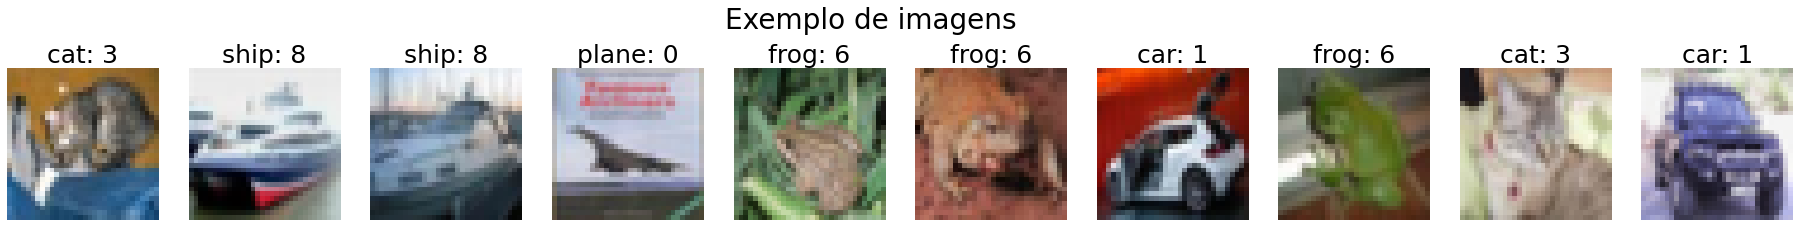

In [ ]:
fig, axs = plt.subplots(1,10, figsize=(32,4));
fig.suptitle('Exemplo de imagens', fontsize=28)
for i in range(10):
  np.random.random_integers(33);
  data, label = test_example[i];
  axs[i].imshow(data.permute((1,2,0)));
  axs[i].set_title(classes[label]+': '+(str(label)),size=25);
  axs[i].axis('off');
  

## Parâmetros de uma rede neural:

-> Uma rede neural artificial possui diversos parâmetros que influenciam diretamente o desempenho do modelo. **Tamanho do mini-bacth, taxa de aprendizado (Learning rate) e Weight decay** são alguns dos hiper-parâmetros que podem ser configurados. 


---


1. **Tamanho do mini-batch:** Define o número de imagens usadas por mini-bacth e consequentemente o número de mini-bacth a serem usados por época. 
 

2. **Taxa de aprendizado:** Esse parâmetro é utilizado para influenciar como a rede utiliza os pesos, sua principal função é guiar a rede até a região onde há o menor custo (loss). É preciso fica atento pois, learning rate maiores podem deixar a rede confusa fazendo com que ela não identifique corretamente o caminho para a ponto que apresenta o menor custo.
<center>
<img alt="Exemplo da descida do gradiente" width="80%" src='http://www.bdhammel.com/assets/learning-rate/lr-types.png'>
</center>

3. **Weight decay(𝜆):** É um termo adicional utilizado para penalizar pesos muito grandes, evitando assim que o modelo tenha grau de liberdade muito alto, oque poderia acarretar provável em  overfitting (O modelo se adapta muito aos dados de treino e acaba não conseguindo generalizar quando aplicado aos dados de teste). Abaixo um exemplo de regularização *L2*.
  <center>
                                    Ê(𝐰)=𝐸(𝐰)+𝜆/2*[(w)ˆ2]


  </center>


<a href="https://jamesmccaffrey.wordpress.com/2019/05/09/the-difference-between-neural-network-l2-regularization-and-weight-decay/"  ><button>Artigo sobre Weight Decay
 </button></a>
  

In [ ]:
# Configurando parâmetros:

args = {
    'epoch_num': 12,     # Número de épocas.
    'lr': 1.5e-3,           # Taxa de aprendizado.
    'weight_decay': 2e-3, # Penalidade L2 (Regularização).
    'batch_size': 128,     # Tamanho do batch.
}

# Dividindo as imagens em mini-batchs:

trainloader=DataLoader(train_set,args['batch_size'],shuffle=True)
testloader=DataLoader(test_set,args['batch_size'],shuffle=True)

# Definindo dispositivo de hardware:

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cuda


##Rede:

 -> **LeNet-5:** Esta arquitetura de rede neural convolucional foi proposta em 1989 por Yann LeCun, e foi originalmente desenvolvida para reconhecer dígitos digitados a mão de correspondências do correio postal dos EUA. 
  
  -> **Arquitetura:** A rede proposta por Yann pode ser separada em duas partes, uma responsável pela extração de características e/ou responsável por classificar imagens em um rótulo. 

  1. **Extrator de características:** Composta de 3 camadas convulsionais (conv) com kernel 5x5 de stride 1 com canais de saída que aumenta progressivamente. Duas dessas camadas conv. São seguidas por camadas de polling e todas elas são seguidas de funções de ativação. Sua principal função é extrair características especificas de cada classe. 

  2. **Camada Flatten:** Nessa camada as imagens produzidas pela camada anterior são redimensionadas para se tornar um array linear de dimensão 1. 

  3. **Classificador:** Recebe a saída da camada flatten e utiliza um Multi Layer Perceptron (MLP), para classificar a imagem de entrada em uma classe. É composta por duas camadas Densas, apenas uma delas é ativada.
  

<center>
<img alt="Arquitetura LeNet-5" width="80%" src='https://www.researchgate.net/publication/328747541/figure/fig1/AS:689664499392513@1541440238195/The-network-structure-of-LeNet5-25.png'>
</center>

In [ ]:
class LeNet5(nn.Module):
  def __init__(self, n_classes):
    super(LeNet5,self).__init__()
    
    # Utilizando a função __init__ conjuntamente com a super iniciamos a classe nn.Module e definimos a arquitetura da rede.
    
    self.feature_extractor=nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=12, kernel_size=5, stride=1),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2),
        nn.Conv2d(in_channels=12, out_channels=36, kernel_size=5, stride=1),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2),
        nn.Conv2d(in_channels=36, out_channels=200, kernel_size=5, stride=1),
        nn.Tanh()
    )
    self.flatten=nn.Sequential(nn.Flatten()
    )
    self.classifier=nn.Sequential(
        nn.Linear(in_features=200, out_features=100),
        nn.Tanh(),
        nn.Linear(in_features=100, out_features=n_classes)
    )
   # A função forward agrupa as camadas definidas anteriormente.

  def forward(self,x):
    x=self.feature_extractor(x)
    x=self.flatten(x)
    logits=self.classifier(x)
    probs=F.softmax(logits)
    return probs

## Net Training:

-> **Função de perda:** Conhecida também como função de custo, visa medir quão bem uma rede executa determinada tarefa, como atribuir o rótulo ou valor correto. Exemplo de função de custo são:




1. **Categorical crossentropy loss:**
<center>
<img alt="Cross-entropy" width="50%" src='https://i.stack.imgur.com/LTx3i.png'>

</center>

2. **Mean squared error loss:**
<center>
<img alt="MSE" width="40%" src='https://pbs.twimg.com/media/Etuc3k4XAAIE1Gb.jpg'>

</center>

---


-> **Otimizador:** São funções matemáticas utilizadas para minimizar a perda(custo) maximizando a performance da rede, diversos tipos já  foram desenvolvidos cada um com  suas vantagens e desvantagens.  Independente da função todos eles são dependentes dos pesos e viés da rede.

- **Adam(Adaptive Moment Estimation):**

<center>
<img alt="Adam Optmizer" width="60%" src='https://miro.medium.com/max/700/1*Qm07YVd-EGf2Ib7C_myDIw.jpeg'>
</center>

- **Exemplo de comparação entre otimizadores:**
<center>
<img alt="Adam Optmizer" width="50%" src='https://miro.medium.com/max/620/1*XVFmo9NxLnwDr3SxzKy-rA.gif'>
</center>

<a href="https://medium.com/mlearning-ai/optimizers-in-deep-learning-7bf81fed78a0"  ><button>Mais sobre otimizadores
 </button></a>

In [ ]:
#Atribuindo modelo a um objeto

Lenet_model=LeNet5(10).to(args['device'])

#Função de Perda

criterion = nn.CrossEntropyLoss().to(args['device'])

#Otimizador

optimizer = optim.Adam(Lenet_model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])

-> **Feed forward:** É o processo pelo qual uma rede propaga uma entrada por diversas camadas, cada uma delas processa entrada conforme sua função de ativação e passa seu output para camada seguinte, até a camada de saída. 

<center>
<img alt="Foward Pass" width="55%" src=https://machinelearningknowledge.ai/wp-content/uploads/2019/10/Feed-Forward-Neural-Network.gif>
</center>



-> **Backpropagation:** Método pelo qual a RNA atualiza os pesos, ocorrendo no sentido contrário ao foward, inciando na última camada e finalizando na primeira camada. O algorítimo de backpropagation computa o gradiente da função de perda. 

<center>
<img alt="Foward Pass" width="55%" src=https://miro.medium.com/max/1280/1*VF9xl3cZr2_qyoLfDJajZw.gif>
</center>



-> **Validação:** Por meio dela o treinamento da rede é verificado consecutivamente determinando assim o quão efetivo o mesmo está sendo. Durante a etapa de validação não é computado o gradiente da função de perda, apenas é avaliado o desempenho da rede em um conjunto de imagens diferentes das de treinamento. 

In [ ]:
def Training_loop(model, criterion, optimizer, epoch_num, trainloader, testloader):
  torch.manual_seed(3)

  #Definindo o número de épocas. Em cada época a itera sobre todo o conjunto de treino. 
  
  epochs = epoch_num

  # Lista vazias para armazenamento de logs 
  epoch_log = []
  loss_log = []
  accuracy_log = []

  # Looping para iteração em cada época. 
  for epoch in range(epochs):  
      print(f'Inicio da Epóca: {epoch+1}...')

      # Cada época começa com loss 0 e a cada mini-batch é computada. 
      running_loss = 0.0

      
      # Colocando o modelo em modo de traino.
      #Iterando sobre trainloader
      model.train()
      for i, data in enumerate(trainloader, 0):
          #Separando as imagens dos labels 
          inputs, labels = data

          # Movendo dados para GPU
          inputs = inputs.to(args['device'])
          labels = labels.to(args['device'])

          # Limpando o gradiente antes do treinamento para cada mini-batch
          
          optimizer.zero_grad()

          # Forward -> backpropagation + optimization
          outputs = model(inputs) # Forward Propagation 
          loss = criterion(outputs, labels) # Obtendo a loss (diferença entre o real e o previsto)
          loss.backward() #Propagando o gradiente por todos os nós. 
          optimizer.step() # Atualizando os pesos. 

          # Visualizando  métricas de treino - época/Iterações/Loss/Acurácia. 
          running_loss += loss.item()
          if i % 50 == 49:    # exibe a loss para 50 mini-batches
              correct = 0 # Variável para contar o número de previsões corretas.
              total = 0 # Contagem total de rótulos. 

              # Durante a validação não é computado gradiente. 
              
              with torch.no_grad():
                  # Iteração sobre testloader 
                  for data in testloader:
                      images, labels = data
                      
                      images = images.to(args['device'])
                      labels = labels.to(args['device'])
                      
                      # Foward propagation das imagens de teste.
                      outputs = model(images)

                      # Obtém a previsão a partir do valor máximo do tensor de saída(Softmax)
                      # dim = 1  especifica o número de dimensões para redução  
                      _, predicted = torch.max(outputs.data, dim = 1)
                      #Adiciona o total de imagens do tensor. 
                      total += labels.size(0)
                      # Soma o total de previsões corretas. 
                      correct += (predicted == labels).sum().item()

                  accuracy = 100 * correct / total
                  epoch_num = epoch + 1
                  actual_loss = running_loss / 50
                  print(f'Epóca: {epoch_num}, Mini-Batches Completos: {(i+1)}, Loss: {actual_loss:.3f}, Acurácia de teste  = {accuracy:.3f}%')
                  running_loss = 0.0

      # Armazenamento de dados de treinamento
      epoch_log.append(epoch_num)
      loss_log.append(actual_loss)
      accuracy_log.append(accuracy)

  print('Treino finalizado')
  return(epoch_log,loss_log,accuracy_log, model)

In [ ]:
model_data=Training_loop(Lenet_model, criterion, optimizer, args['epoch_num'], trainloader, testloader)

Inicio da Epóca: 1...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epóca: 1, Mini-Batches Completos: 50, Loss: 2.206, Acurácia de teste  = 29.090%
Epóca: 1, Mini-Batches Completos: 100, Loss: 2.148, Acurácia de teste  = 31.390%
Epóca: 1, Mini-Batches Completos: 150, Loss: 2.130, Acurácia de teste  = 33.300%
Epóca: 1, Mini-Batches Completos: 200, Loss: 2.125, Acurácia de teste  = 34.720%
Epóca: 1, Mini-Batches Completos: 250, Loss: 2.108, Acurácia de teste  = 34.590%
Epóca: 1, Mini-Batches Completos: 300, Loss: 2.107, Acurácia de teste  = 35.310%
Epóca: 1, Mini-Batches Completos: 350, Loss: 2.105, Acurácia de teste  = 36.060%
Inicio da Epóca: 2...
Epóca: 2, Mini-Batches Completos: 50, Loss: 2.091, Acurácia de teste  = 35.760%
Epóca: 2, Mini-Batches Completos: 100, Loss: 2.091, Acurácia de teste  = 37.560%
Epóca: 2, Mini-Batches Completos: 150, Loss: 2.084, Acurácia de teste  = 36.180%
Epóca: 2, Mini-Batches Completos: 200, Loss: 2.082, Acurácia de teste  = 38.190%
Epóca: 2, Mini-Batches Completos: 250, Loss: 2.084, Acurácia de teste  = 37.490%
Epóca: 2

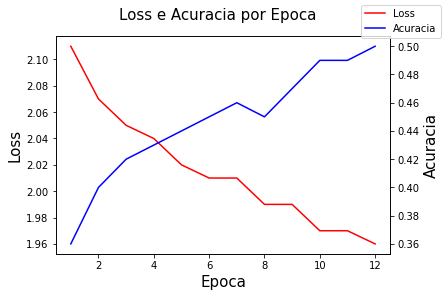

In [ ]:
fig, ax1 = plt.subplots() 
fig.suptitle('Loss e Acuracia por Epoca',size=15)
ax1.set_xlabel('Epoca',size=15) 
ax1.set_ylabel('Loss',size=15) 
ax1.plot(model_data[0],[round(l,2) for l in model_data[1]], color = 'red', label='Loss') 

ax2 = ax1.twinx() 
ax2.plot(model_data[0],[round(ac/100,2) for ac in model_data[2]], color = 'blue', label='Acuracia') 
fig.legend()
plt.ylabel('Acuracia' ,size=15)
# plt.tight_layout()
plt.show()

É possível ver que a rede apresenta uma redução de loss e ganho de acurácia significativos até a 9 época, porém vai perdendo a capacidade de aprendizado, o que pode ser causado pela arquitetura da rede, que foi originalmente construída para identificação de dígitos em imagens em escalas de cinza e as imagens do dataset Cifar-10 apresentam 3 canais(RGB).

In [ ]:
# torch.save(model_data[3].state_dict(),'Lenet_CIFAR10_weights')

In [ ]:
# model = LeNet5(10)
# model.load_state_dict(torch.load('/content/Lenet_CIFAR10_treino'))
# model.eval()